# Importing Libraries

In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import torch
from tqdm import tqdm
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading Data

In [2]:
ground_truth = pd.read_csv("Data/gtruth_codes_512.tsv", sep="\t")

In [3]:
train_images = []
image_names = []
train_images_path = "Data/BCSS/train"
for i in os.listdir(train_images_path)[:6000]:
    image_names.append(i)
    img = cv2.imread(os.path.join(train_images_path, i))
    train_images.append(img)



In [4]:
mask_images = []

mask_images_path = "Data/BCSS/train_mask"
for i in image_names:
    img = cv2.imread(os.path.join(mask_images_path, i))
    mask_images.append(img)





# Unique Classes and Helper Functions

In [5]:
# Finding Unique Classes
unique_classes = set()
for i in mask_images:
    for j in np.unique(i):
        unique_classes.add(j)

print(unique_classes)

{0, 1, 2}


In [6]:
def preprocess_mask(masks,class_num):
    
    one_hot_masks = []
    for i in range(len(masks)):
        mask = masks[i][:,:,0]
        one_hot_mask = np.zeros((mask.shape[0],mask.shape[1],class_num),dtype=int)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                one_hot_mask[i,j,mask[i,j]] = 1
        one_hot_masks.append(one_hot_mask)
       
    return np.array(one_hot_masks)


def prediction_To_mask(pred,class_Num): 

    masks = []
    for img in pred:
        
    
        mask = np.zeros((img.shape[0],img.shape[1],class_Num),dtype=int)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                mask[i,j,:] = np.argmax(img[i,j,:])
        masks.append(mask)
    return masks

def convert_mask_to_RGB(mask_Exp):
    for i in range(len(mask_Exp)):
        for j in range(len(mask_Exp)):
            if mask_Exp[i][j][0] ==  0 : 
                mask_Exp[i][j] =  [255,0,0] 
            elif mask_Exp[i][j][0] == 1:
                mask_Exp[i][j] = [0,255,0]
            elif mask_Exp[i][j][0] == 2:
                mask_Exp[i][j] = [0,0,255]
    return mask_Exp

  

In [7]:
def PlotImage(images ,mask_images ,class_dict):
    fig,axs = plt.subplots(len(images),2,figsize=(10,len(images) * 2))
    
    axs[0,0].set_title("Original Image")
    axs[0,1].set_title("Ground Truth Mask")
    for i in range(len(images)):
        axs[i,0].imshow(images[i])
        mask_images[i] = convert_mask_to_RGB(mask_images[i])
        
        axs[i,1].imshow(mask_images[i])
        patches = [mpatches.Patch(color=class_dict[i]/255, label=i) for i in class_dict.keys()]
        axs[i,1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def PlotPredictions(images,mask_images,prediction_masks,class_dict):
    fig,axs = plt.subplots(len(images),3,figsize=(15,len(images) * 3))
    
    axs[0,0].set_title("Original Image")
    axs[0,1].set_title("Ground Truth Mask")
    axs[0,2].set_title("Predicted Mask")
    for i in range(len(images)):
        axs[i,0].imshow(images[i])
        mask_images[i] = convert_mask_to_RGB(mask_images[i])
        axs[i,1].imshow(mask_images[i])
        prediction_masks[i] = convert_mask_to_RGB(prediction_masks[i])
        axs[i,2].imshow(prediction_masks[i])
        patches = [mpatches.Patch(color=class_dict[i]/255, label=i) for i in class_dict.keys()]
        axs[i,1].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        axs[i,2].legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def PlotLosses(training_loss,validation_loss,title):
    plt.plot(training_loss,label="Training Loss")
    plt.plot(validation_loss,label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(title)
    plt.show()

In [8]:
labels = pd.read_csv("Data/gtruth_codes_512.tsv", sep="\t")
labels = labels.iloc[:3,:]

colors = [np.array([255,0,0]),np.array([0,255,0]),np.array([0,0,255])]
class_dict = {}
for i in range(len(labels)):
    class_dict[labels.iloc[i,0]] = colors[i]



In [9]:
print(class_dict)

{'outside_roi': array([255,   0,   0]), 'tumor': array([  0, 255,   0]), 'stroma': array([  0,   0, 255])}


# EXAMPLE IMAGES

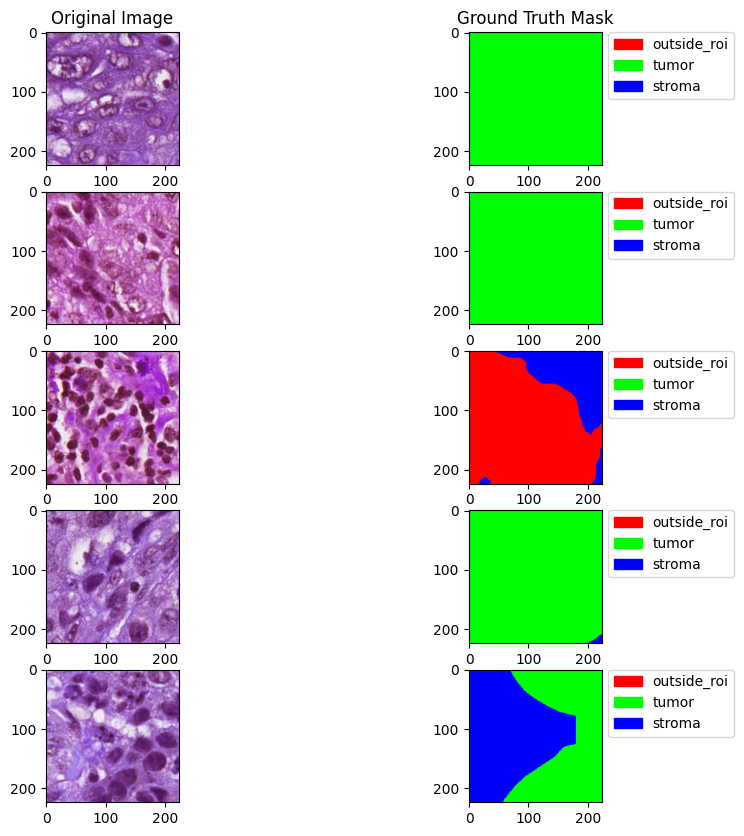

In [10]:
random_inds = np.random.randint(0,len(train_images),5)
images_exp = []
mask_images_exp = []
for i in random_inds:
    images_exp.append(train_images[i].copy())
    mask_images_exp.append(mask_images[i].copy())
PlotImage(images_exp,mask_images_exp,class_dict)

# Class Distrubition

In [11]:
count_dict = {"0" : 0, "1" : 0 , "2" : 0}
for i in range(len(mask_images)):
    pixels = mask_images[i].copy().flatten()
    classes,counts = np.unique(pixels,return_counts=True)
    
    for i in range(len(classes)):
        count_dict[str(classes[i])] += counts[i] / 3


count_dict

{'0': 63342008.0, '1': 143845069.0, '2': 93868923.0}

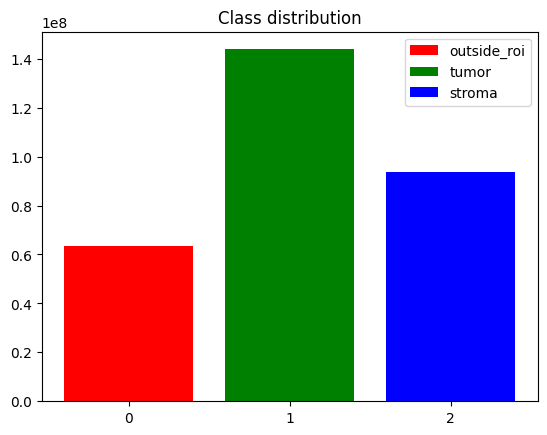

In [12]:
plt.bar(count_dict.keys(),count_dict.values(),label=["outside_roi","tumor","stroma"],color=["red","green","blue"])
plt.title("Class distribution")
plt.legend()

# Data Preparation

In [13]:
val_images = np.array(train_images[:500])
val_masks = np.array(mask_images[:500])
train_images = np.array(train_images[500:6000])
mask_images = np.array(mask_images[500:6000])
train_images = train_images / 255.0
val_images = val_images / 255.0
masks_onehot = preprocess_mask(mask_images,3)
val_masks_onehot = preprocess_mask(val_masks,3)

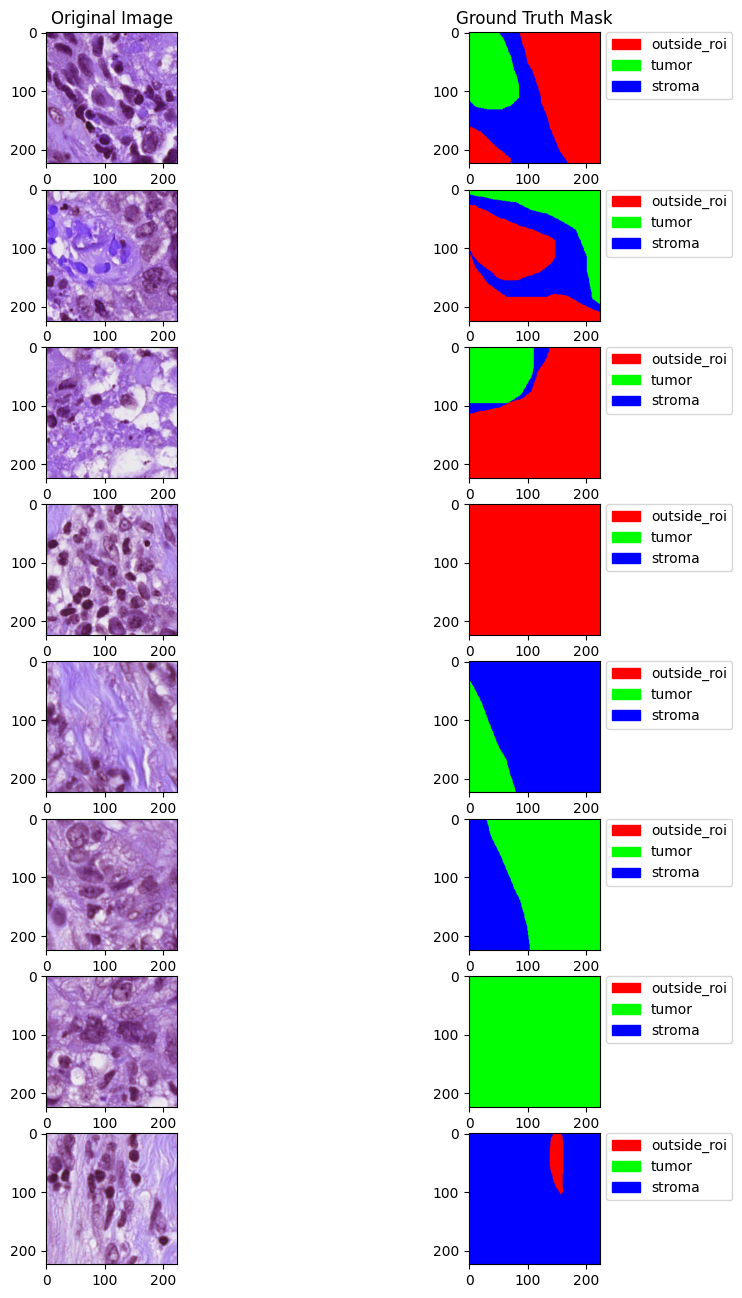

In [17]:

images_exp = []
mask_images_exp = []
start_ind = np.random.randint(0,len(train_images)-8,1)[0]
for i in range(start_ind,start_ind+8):
    images_exp.append(train_images[i].copy())
    mask_images_exp.append(mask_images[i].copy())
PlotImage(images_exp,mask_images_exp,class_dict)


# Custom U-Net Model

In [11]:
import torch
import torch.nn as nn
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self,input_channel = 3, out_channel = 3, filter_sizes = [32,64,128]):
        super(Unet,self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.softmax = nn.Softmax2d()

        #Encoder
        for i in filter_sizes:
            self.encoder.append(DoubleConv(input_channel,i))
            input_channel = i
        
        #Decoder
        for i in reversed(filter_sizes):
            self.decoder.append(nn.ConvTranspose2d(i*2,i,kernel_size=2,stride=2))
            self.decoder.append(DoubleConv(i*2,i))
       
        self.bottleneck = DoubleConv(filter_sizes[-1],filter_sizes[-1]*2)
        self.final_layer = nn.Conv2d(filter_sizes[0],out_channel,kernel_size=1)

    def forward(self,x):
        connections = []
        for enc in self.encoder:
            x = enc(x)
            connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        connections = connections[::-1]
        for index in range(0,len(self.decoder),2):
            x = self.decoder[index](x)
            connection = connections[index//2]
            if x.shape != connection.shape:
                x = nn.functional.interpolate(x,size = connection.shape[2:])
            concat_connection = torch.cat([connection,x],dim=1)
            x = self.decoder[index+1](concat_connection)
        
        x = self.final_layer(x)
        
        x  = self.softmax(x)
       
        return x
        #return nn.Softmax(dim=1)(x)
    
    def train(self,images,masks,val_images,val_masks,epochs,learning_rate,batch_size = 32):
        optimizer = torch.optim.Adam(self.parameters(),lr = learning_rate)
        criterion = nn.CrossEntropyLoss()
        epoch_loss = []
        epoch_val_loss = []
        for epoch in (range(epochs)):
            training_losses = []
            validation_losses = []

            for i in tqdm(range(0,len(images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = self(batch_images)
                
                loss = criterion(preds,batch_masks)
                loss.backward()
                
                optimizer.step()
                training_losses.append(loss.item())
            
            for i in (range(0,len(val_images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(val_images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(val_masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = self(batch_images)
                
                loss = criterion(preds,batch_masks)
                
                validation_losses.append(loss.item())

            epoch_loss.append(np.mean(training_losses))
            epoch_val_loss.append(np.mean(validation_losses))
            

            
            
            
            print(f"Epoch : {epoch+1}, Training Loss : {np.mean(training_losses)}, Validation Loss : {np.mean(validation_losses)}")
        #return training_losses,validation_losses
        

    def predict(self,input_img):
        input_img = torch.Tensor(input_img).permute(0,3,1,2).to(device)
        prediction = self(input_img).permute(0,2,3,1)
        
        return prediction.cpu().detach().numpy()
            

## Model Training

In [16]:
model = Unet(3,3).to(device)

model.train(train_images,masks_onehot,val_images,val_masks_onehot,50,0.00001,batch_size=16)

c:\Users\burak\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 344/344 [08:24<00:00,  1.47s/it]


Epoch : 1, Training Loss : 1.0474422641618306, Validation Loss : 0.9911469798535109


100%|██████████| 344/344 [08:31<00:00,  1.49s/it]


Epoch : 2, Training Loss : 0.9875842166501422, Validation Loss : 0.9645258449018002


100%|██████████| 344/344 [08:27<00:00,  1.48s/it]


Epoch : 3, Training Loss : 0.9674394501503124, Validation Loss : 0.9470537770539522


100%|██████████| 344/344 [08:17<00:00,  1.45s/it]


Epoch : 4, Training Loss : 0.9543966533139695, Validation Loss : 0.9346272591501474


100%|██████████| 344/344 [06:49<00:00,  1.19s/it]


Epoch : 5, Training Loss : 0.9444493923422902, Validation Loss : 0.9266145378351212


100%|██████████| 344/344 [07:31<00:00,  1.31s/it]


Epoch : 6, Training Loss : 0.9361062711754511, Validation Loss : 0.9208629280328751


100%|██████████| 344/344 [08:00<00:00,  1.40s/it]


Epoch : 7, Training Loss : 0.9288040007962737, Validation Loss : 0.9159260224550962


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 8, Training Loss : 0.9222193653153818, Validation Loss : 0.9116438236087561


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 9, Training Loss : 0.9161125953460849, Validation Loss : 0.9080388639122248


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 10, Training Loss : 0.9103229026808295, Validation Loss : 0.9049990102648735


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 11, Training Loss : 0.9047429663843887, Validation Loss : 0.9023883901536465


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 12, Training Loss : 0.8992453489539235, Validation Loss : 0.8996513094753027


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 13, Training Loss : 0.8938598741972169, Validation Loss : 0.8969821389764547


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 14, Training Loss : 0.8886338513950969, Validation Loss : 0.8940255884081125


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 15, Training Loss : 0.8835796980663787, Validation Loss : 0.8911501914262772


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 16, Training Loss : 0.8787084417634232, Validation Loss : 0.8886877577751875


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 17, Training Loss : 0.874015569340351, Validation Loss : 0.8863810412585735


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 18, Training Loss : 0.8694919063601383, Validation Loss : 0.8843207620084286


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 19, Training Loss : 0.8651477581886358, Validation Loss : 0.88236965239048


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 20, Training Loss : 0.860922911312691, Validation Loss : 0.8804733604192734


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 21, Training Loss : 0.8567914101620053, Validation Loss : 0.8786152265965939


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 22, Training Loss : 0.8527565915570703, Validation Loss : 0.8770241942256689


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 23, Training Loss : 0.8488129124391911, Validation Loss : 0.875564731657505


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 24, Training Loss : 0.8449645160242568, Validation Loss : 0.8742301724851131


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 25, Training Loss : 0.8411840061808742, Validation Loss : 0.8729526065289974


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 26, Training Loss : 0.8374921974054602, Validation Loss : 0.8717701137065887


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 27, Training Loss : 0.8338811522306397, Validation Loss : 0.8706464394927025


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 28, Training Loss : 0.830360688615677, Validation Loss : 0.8698198702186346


100%|██████████| 344/344 [06:43<00:00,  1.17s/it]


Epoch : 29, Training Loss : 0.8269067706410275, Validation Loss : 0.8690549544990063


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 30, Training Loss : 0.8235399440623993, Validation Loss : 0.8685977775603533


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 31, Training Loss : 0.8202244661921678, Validation Loss : 0.8683089967817068


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 32, Training Loss : 0.8169575569241546, Validation Loss : 0.8680084068328142


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 33, Training Loss : 0.8137181269568067, Validation Loss : 0.868102665990591


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 34, Training Loss : 0.8105489265087039, Validation Loss : 0.8682704251259565


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 35, Training Loss : 0.8074375337292982, Validation Loss : 0.8685617782175541


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 36, Training Loss : 0.8043711225307265, Validation Loss : 0.8688889499753714


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 37, Training Loss : 0.8013277873396873, Validation Loss : 0.8690669052302837


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 38, Training Loss : 0.7983244908756988, Validation Loss : 0.8693495281040668


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 39, Training Loss : 0.7953794851552608, Validation Loss : 0.8695347122848034


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 40, Training Loss : 0.7924686706689901, Validation Loss : 0.8696336504071951


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 41, Training Loss : 0.7895798766335775, Validation Loss : 0.8699506614357233


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 42, Training Loss : 0.7867034349677174, Validation Loss : 0.8703449666500092


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 43, Training Loss : 0.7838357255555862, Validation Loss : 0.8705443348735571


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 44, Training Loss : 0.7809980007451635, Validation Loss : 0.8708088025450706


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 45, Training Loss : 0.7781987564508305, Validation Loss : 0.8712623715400696


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 46, Training Loss : 0.7754283342943635, Validation Loss : 0.8715252559632063


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 47, Training Loss : 0.7726622899604398, Validation Loss : 0.8717158753424883


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 48, Training Loss : 0.7699263927548431, Validation Loss : 0.8723200559616089


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 49, Training Loss : 0.7672291292354118, Validation Loss : 0.8727258630096912


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 50, Training Loss : 0.7645822557252507, Validation Loss : 0.8729067966341972


In [17]:
# save weights
torch.save(model.state_dict(), "model_weights_nonaugment50Epoch.pth")


In [18]:
model.train(train_images,masks_onehot,val_images,val_masks_onehot,20,0.00001,batch_size=16)

100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 1, Training Loss : 0.7624616106582243, Validation Loss : 0.8722477592527866


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 2, Training Loss : 0.7593375518918037, Validation Loss : 0.8731468580663204


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 3, Training Loss : 0.7567209639521533, Validation Loss : 0.8742642533034086


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 4, Training Loss : 0.754161884098552, Validation Loss : 0.8755035791546106


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 5, Training Loss : 0.7516479857785757, Validation Loss : 0.8763638250529766


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 6, Training Loss : 0.7491957141562949, Validation Loss : 0.8770445678383112


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 7, Training Loss : 0.7467563639200011, Validation Loss : 0.8775831647217274


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 8, Training Loss : 0.7443553805351257, Validation Loss : 0.8779710177332163


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 9, Training Loss : 0.741968295428642, Validation Loss : 0.878287186846137


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 10, Training Loss : 0.7396040971195975, Validation Loss : 0.8785272128880024


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 11, Training Loss : 0.7372608176150988, Validation Loss : 0.8791917059570551


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 12, Training Loss : 0.7349415852926499, Validation Loss : 0.8800503741949797


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 13, Training Loss : 0.7326550790390303, Validation Loss : 0.8811679743230343


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 14, Training Loss : 0.7303984587968781, Validation Loss : 0.882672468200326


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 15, Training Loss : 0.7281624355981516, Validation Loss : 0.8841926362365484


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 16, Training Loss : 0.7259504289128059, Validation Loss : 0.8857703115791082


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 17, Training Loss : 0.7237695290945297, Validation Loss : 0.8876822534948587


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 18, Training Loss : 0.7216057690770127, Validation Loss : 0.8895436991006136


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 19, Training Loss : 0.7194666027329689, Validation Loss : 0.8918764404952526


100%|██████████| 344/344 [06:48<00:00,  1.19s/it]


Epoch : 20, Training Loss : 0.7173813957461092, Validation Loss : 0.8945965897291899


In [19]:
torch.save(model.state_dict(), "model_weights_nonaugment70Epoch.pth")

### Losses are written in list because training is done in different times. Losses are recorded in list below.

In [14]:
train_loss = [  1.0474422641618306,
                0.9875842166501422,
                0.9674394501503124,
                0.9543966533139695,
                0.9444493923422902,
                0.9361062711754511,
                0.9288040007962737,
                0.9222193653153818,
                0.9161125953460849,
                0.9103229026808295,
                0.9047429663843887,
                0.8992453489539235,
                0.8938598741972169,
                0.8886338513950969,
                0.8835796980663787,
                0.8787084417634232,
                0.874015569340351,
                0.8694919063601383,
                0.8651477581886358,
                0.860922911312691,
                0.8567914101620053,
                0.8527565915570703,
                0.8488129124391911,
                0.8449645160242568,
                0.8411840061808742,
                0.8374921974054602,
                0.8338811522306397,
                0.830360688615677,
                0.8269067706410275,
                0.8235399440623993,
                0.8202244661921678, 
                0.8169575569241546,
                0.8137181269568067, 
                0.8105489265087039, 
                0.8074375337292982,
                0.8043711225307265, 
                0.8013277873396873,
                0.7983244908756988, 
                0.7953794851552608, 
                0.7924686706689901,
                0.7895798766335775,
                0.7867034349677174,
                0.7838357255555862,
                0.7809980007451635, 
                0.7781987564508305,
                0.7754283342943635, 
                0.7726622899604398,
                0.7699263927548431,
                0.7672291292354118, 
                0.7645822557252507,
                0.7624616,
                0.7593375,
                0.7567209,
                0.7541618,
                0.7516479,
                0.7491957,
                0.7467563,
                0.7443553,
                0.7419682,
                0.7396040,
                0.7372608,
                0.7349415,
                0.7326550,
                0.7303984,
                0.7281624,
                0.7259504,
                0.7237695,
                0.7216057,
                0.7194666,
                0.7173813,
                ]
val_loss = [0.9911469798535109,
0.9645258449018002,
0.9470537770539522,
0.9346272591501474,
0.9266145378351212,
0.9208629280328751,
0.9159260224550962,
0.9116438236087561,
0.9080388639122248,
0.9049990102648735,
0.9023883901536465,
0.8996513094753027,
0.8969821389764547,
0.8940255884081125,
0.8911501914262772,
0.8886877577751875,
0.8863810412585735,
0.8843207620084286,
0.88236965239048,
0.8804733604192734,
0.8786152265965939,
0.8770241942256689,
0.875564731657505,
0.8742301724851131,
0.8729526065289974,
0.8717701137065887,
0.8706464394927025,
0.8698198702186346,
0.8690549544990063,
0.8685977775603533,
0.8683089967817068,
0.8680084068328142,
0.868102665990591,
0.8682704251259565,
0.8685617782175541,
0.8688889499753714,
0.8690669052302837,
0.8693495281040668,
0.8695347122848034,
0.8696336504071951,
0.8699506614357233,
0.8703449666500092,
0.8705443348735571,
0.8708088025450706,
0.8712623715400696,
0.8715252559632063,
0.8717158753424883,
0.8723200559616089,
0.8727258630096912,
0.8729067966341972,
0.8722477592527866,
0.8731468580663204,
0.8742642533034086,
0.8755035791546106,
0.8763638250529766,
0.8770445678383112,
0.8775831647217274,
0.8779710177332163,
0.878287186846137,
0.8785272128880024,
0.8791917059570551,
0.8800503741949797,
0.8811679743230343,
0.882672468200326,
0.8841926362365484,
0.8857703115791082,
0.8876822534948587,
0.8895436991006136,
0.8918764404952526,
0.8945965897291899]

# Loss Plot (Custom Model)

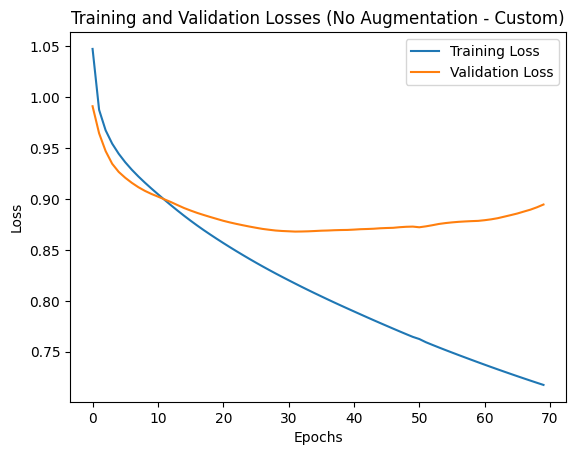

In [15]:
PlotLosses(train_loss,val_loss,title = "Training and Validation Losses (No Augmentation - Custom)")

### Loading Model

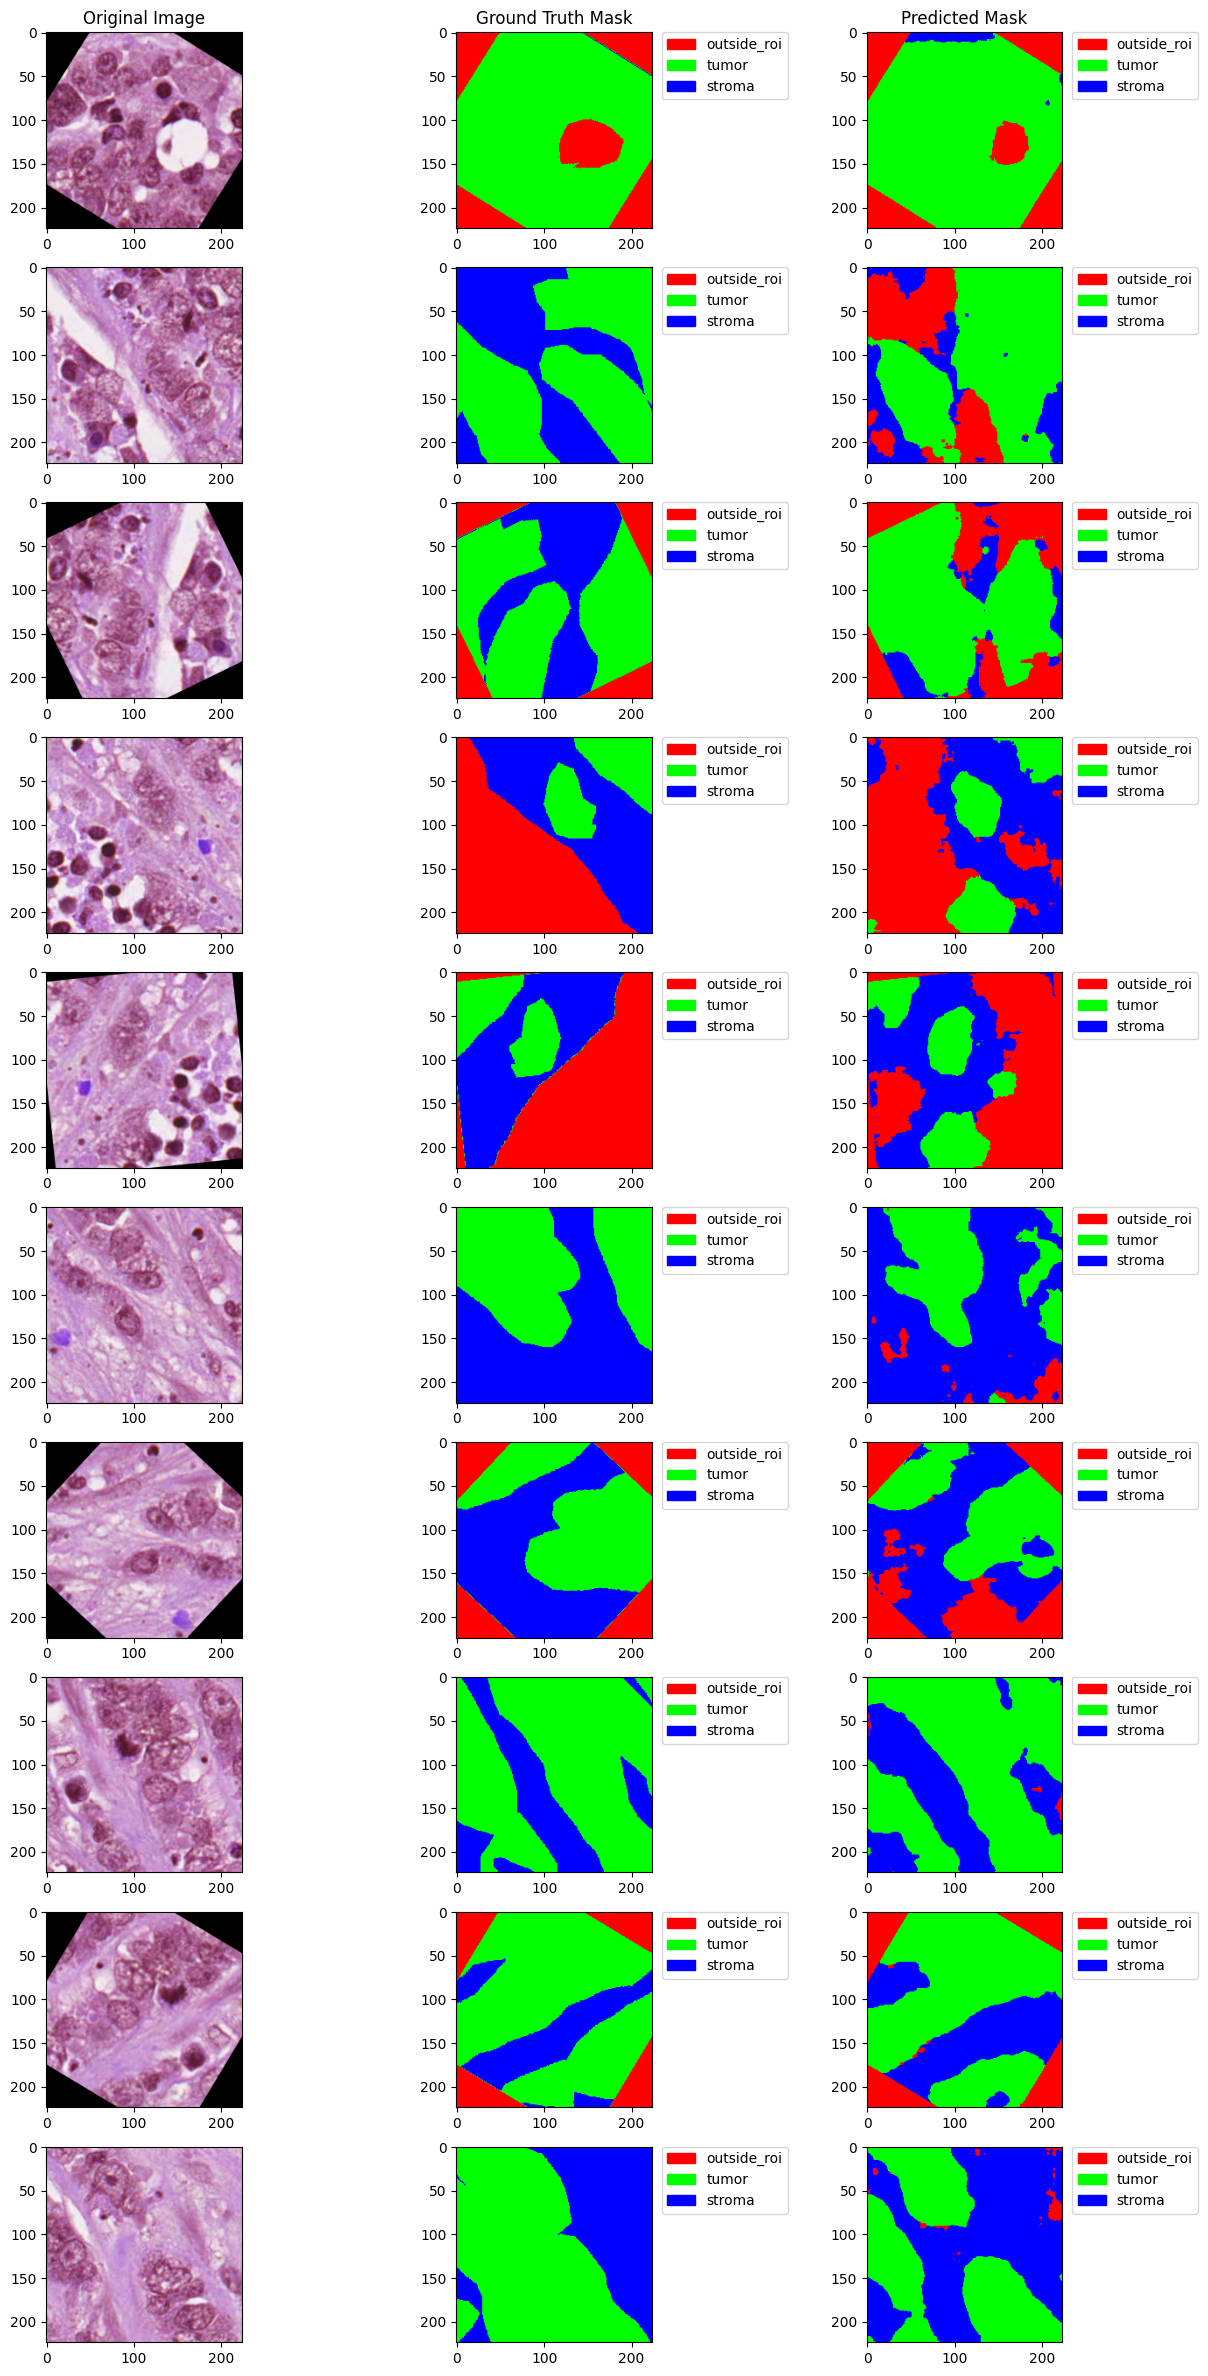

In [19]:
"""
## PREDICTION

model = Unet(3,3).to(device)
model.load_state_dict(torch.load("model_weights_110_Epoch.pth"))

preds = model.predict(val_images[15:25])
preds_masks = prediction_To_mask(preds,3)

PlotPredictions(val_images[15:25],val_masks[15:25],preds_masks,class_dict)
"""

# Pretrained Unet

In [20]:
def train(model,images,masks,val_images,val_masks,epochs,learning_rate,batch_size = 32):
        optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
        criterion = nn.CrossEntropyLoss()
        epoch_loss = []
        epoch_val_loss = []
        for epoch in (range(epochs)):
            training_losses = []
            validation_losses = []

            for i in tqdm(range(0,len(images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = model(batch_images)
                
                loss = criterion(preds,batch_masks)
                loss.backward()
                
                optimizer.step()
                training_losses.append(loss.item())
            
            for i in (range(0,len(val_images),batch_size)):
                optimizer.zero_grad()
                batch_images = torch.Tensor(val_images[i:i+batch_size]).permute(0,3,1,2).to(device)
                batch_masks = torch.Tensor(val_masks[i:i+batch_size]).permute(0,3,1,2).to(device)
                preds = model(batch_images)
                
                loss = criterion(preds,batch_masks)
                
                validation_losses.append(loss.item())

            epoch_loss.append(np.mean(training_losses))
            epoch_val_loss.append(np.mean(validation_losses))
            

            
            
            
            print(f"Epoch : {epoch+1}, Training Loss : {np.mean(training_losses)}, Validation Loss : {np.mean(validation_losses)}")
        #return training_losses,validation_losses


def load_model(weights_path = None,gpu=True):
    Pretrained_Unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
    Pretrained_Unet.conv = nn.Conv2d(32,3,kernel_size=1)
    
    for param in Pretrained_Unet.conv.parameters():
        param.requires_grad = True
    
    if gpu:
        Pretrained_Unet = Pretrained_Unet.to(device)
    if weights_path:
        Pretrained_Unet.load_state_dict(torch.load(weights_path))
        
    return Pretrained_Unet

## Training

In [21]:
Pretrained_Unet = load_model()

train(Pretrained_Unet,train_images,masks_onehot,val_images,val_masks_onehot,20,0.0001,batch_size=16)


Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
100%|██████████| 344/344 [07:16<00:00,  1.27s/it]


Epoch : 1, Training Loss : 1.0019749836173169, Validation Loss : 0.9457669090479612


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 2, Training Loss : 0.9569079434109289, Validation Loss : 0.9336328748613596


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 3, Training Loss : 0.9365566111234731, Validation Loss : 0.9139334764331579


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 4, Training Loss : 0.9179073433543361, Validation Loss : 0.8974940869957209


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 5, Training Loss : 0.9031734447493109, Validation Loss : 0.8847148101776838


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 6, Training Loss : 0.8927800201399382, Validation Loss : 0.8761628437787294


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 7, Training Loss : 0.8807981977629107, Validation Loss : 0.8716377206146717


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 8, Training Loss : 0.867082089878792, Validation Loss : 0.8720194566994905


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 9, Training Loss : 0.8523882838875748, Validation Loss : 0.8710648994892836


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 10, Training Loss : 0.836410429588584, Validation Loss : 0.8531405422836542


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 11, Training Loss : 0.8228890072814253, Validation Loss : 0.8404910452663898


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 12, Training Loss : 0.8130421359525171, Validation Loss : 0.8349566776305437


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 13, Training Loss : 0.8043429728510768, Validation Loss : 0.8284238129854202


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 14, Training Loss : 0.7971303506299506, Validation Loss : 0.8236864916980267


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 15, Training Loss : 0.7896062295104183, Validation Loss : 0.8200385756790638


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 16, Training Loss : 0.7822487563934437, Validation Loss : 0.8201213497668505


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 17, Training Loss : 0.7756763719195543, Validation Loss : 0.8201058357954025


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 18, Training Loss : 0.7667392270509586, Validation Loss : 0.8217976167798042


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 19, Training Loss : 0.7595230070657508, Validation Loss : 0.8236939553171396


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 20, Training Loss : 0.7521999005314915, Validation Loss : 0.8152117058634758


In [23]:
train(Pretrained_Unet,train_images,masks_onehot,val_images,val_masks_onehot,30,0.0001,batch_size=16)

100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 1, Training Loss : 0.7460862477851469, Validation Loss : 0.8196628373116255


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 2, Training Loss : 0.7395810056910959, Validation Loss : 0.8249868880957365


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 3, Training Loss : 0.733275635644447, Validation Loss : 0.8318259343504906


100%|██████████| 344/344 [09:04<00:00,  1.58s/it]


Epoch : 4, Training Loss : 0.728283267728118, Validation Loss : 0.8867108412086964


100%|██████████| 344/344 [09:02<00:00,  1.58s/it]


Epoch : 5, Training Loss : 0.7263396993972534, Validation Loss : 0.8253251500427723


100%|██████████| 344/344 [09:03<00:00,  1.58s/it]


Epoch : 6, Training Loss : 0.7179827525518662, Validation Loss : 0.8290148563683033


100%|██████████| 344/344 [07:16<00:00,  1.27s/it]


Epoch : 7, Training Loss : 0.7109892496535944, Validation Loss : 0.8211855664849281


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 8, Training Loss : 0.7030665905669679, Validation Loss : 0.8216932341456413


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 9, Training Loss : 0.701359959189282, Validation Loss : 0.8108089156448841


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 10, Training Loss : 0.6972423835202705, Validation Loss : 0.8614280708134174


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 11, Training Loss : 0.6930553015581397, Validation Loss : 0.9040529616177082


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 12, Training Loss : 0.6870468302175056, Validation Loss : 0.8625401891767979


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 13, Training Loss : 0.6825836082530576, Validation Loss : 0.8092477917671204


100%|██████████| 344/344 [07:17<00:00,  1.27s/it]


Epoch : 14, Training Loss : 0.6837722491039786, Validation Loss : 0.832055164501071


100%|██████████| 344/344 [08:24<00:00,  1.47s/it]


Epoch : 15, Training Loss : 0.679383015216783, Validation Loss : 0.8245017156004906


100%|██████████| 344/344 [09:09<00:00,  1.60s/it]


Epoch : 16, Training Loss : 0.6721393776147865, Validation Loss : 0.8258512411266565


100%|██████████| 344/344 [09:03<00:00,  1.58s/it]


Epoch : 17, Training Loss : 0.6656514231202214, Validation Loss : 0.8453590255230665


100%|██████████| 344/344 [09:03<00:00,  1.58s/it]


Epoch : 18, Training Loss : 0.6619544408695642, Validation Loss : 0.8338506165891886


100%|██████████| 344/344 [09:04<00:00,  1.58s/it]


Epoch : 19, Training Loss : 0.6662264814557031, Validation Loss : 0.8242100067436695


100%|██████████| 344/344 [09:07<00:00,  1.59s/it]


Epoch : 20, Training Loss : 0.6698235658019088, Validation Loss : 0.8454366233199835


100%|██████████| 344/344 [09:04<00:00,  1.58s/it]


Epoch : 21, Training Loss : 0.6571506192517835, Validation Loss : 0.833370741456747


100%|██████████| 344/344 [09:04<00:00,  1.58s/it]


Epoch : 22, Training Loss : 0.6510537420940954, Validation Loss : 0.8551476690918207


100%|██████████| 344/344 [09:03<00:00,  1.58s/it]


Epoch : 23, Training Loss : 0.6458547359635664, Validation Loss : 0.8373216539621353


100%|██████████| 344/344 [09:02<00:00,  1.58s/it]


Epoch : 24, Training Loss : 0.6428456008434296, Validation Loss : 0.8443037942051888


100%|██████████| 344/344 [09:03<00:00,  1.58s/it]


Epoch : 25, Training Loss : 0.640917748559353, Validation Loss : 0.8289278596639633


100%|██████████| 344/344 [09:03<00:00,  1.58s/it]


Epoch : 26, Training Loss : 0.6379113990900128, Validation Loss : 0.8404577430337667


100%|██████████| 344/344 [09:10<00:00,  1.60s/it]


Epoch : 27, Training Loss : 0.6381445204795793, Validation Loss : 0.836900481954217


100%|██████████| 344/344 [09:00<00:00,  1.57s/it]


Epoch : 28, Training Loss : 0.631879270769829, Validation Loss : 0.8498166911303997


100%|██████████| 344/344 [09:28<00:00,  1.65s/it]


Epoch : 29, Training Loss : 0.6296118884239086, Validation Loss : 0.8458915259689093


100%|██████████| 344/344 [09:31<00:00,  1.66s/it]


Epoch : 30, Training Loss : 0.6262724330258924, Validation Loss : 0.824949461966753


In [24]:
torch.save(Pretrained_Unet.state_dict(), "Pretrained_Unet_nonaugment50Epoch.pth")

### Losses are written in list because training is done in different times. Losses are recorded in list below.

In [16]:
train_loss = [1.0019749836173169,
0.9569079434109289,
0.9365566111234731,
0.9179073433543361,
0.9031734447493109,
0.8927800201399382,
0.8807981977629107,
0.867082089878792,
0.8523882838875748,
0.836410429588584,
0.8228890072814253,
0.8130421359525171,
0.8043429728510768,
0.7971303506299506,
0.7896062295104183,
0.7822487563934437,
0.7756763719195543,
0.7667392270509586,
0.7595230070657508,
0.7521999005314915,
0.7460862477851469,
0.7395810056910959,
0.733275635644447,
0.728283267728118,
0.7263396993972534,
0.7179827525518662,
0.7109892496535944,
0.7030665905669679,
0.701359959189282,
0.6972423835202705,
0.6930553015581397,
0.6870468302175056,
0.6825836082530576,
0.6837722491039786,
0.679383015216783,
0.6721393776147865,
0.6656514231202214,
0.6619544408695642,
0.6662264814557031,
0.6698235658019088,
0.6571506192517835,
0.6510537420940954,
0.6458547359635664,
0.6428456008434296,
0.640917748559353,
0.6379113990900128,
0.6381445204795793,
0.631879270769829,
0.6296118884239086,
0.6262724330258924]
val_loss = [0.9457669090479612,
0.9336328748613596,
0.9139334764331579,
0.8974940869957209,
0.8847148101776838,
0.8761628437787294,
0.8716377206146717,
0.8720194566994905,
0.8710648994892836,
0.8531405422836542,
0.8404910452663898,
0.8349566776305437,
0.8284238129854202,
0.8236864916980267,
0.8200385756790638,
0.8201213497668505,
0.8201058357954025,
0.8217976167798042,
0.8236939553171396,
0.8152117058634758,
0.8196628373116255,
0.8249868880957365,
0.8318259343504906,
0.8867108412086964,
0.8253251500427723,
0.8290148563683033,
0.8211855664849281,
0.8216932341456413,
0.8108089156448841,
0.8614280708134174,
0.9040529616177082,
0.8625401891767979,
0.8092477917671204,
0.832055164501071,
0.8245017156004906,
0.8258512411266565,
0.8453590255230665,
0.8338506165891886,
0.8242100067436695,
0.8454366233199835,
0.833370741456747,
0.8551476690918207,
0.8373216539621353,
0.8443037942051888,
0.8289278596639633,
0.8404577430337667,
0.836900481954217,
0.8498166911303997,
0.8458915259689093,
0.824949461966753
]

# Loss Plot (Pretrained Model)

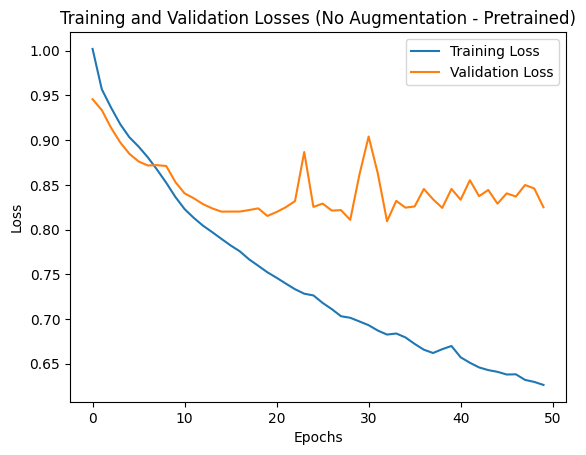

In [19]:
PlotLosses(train_loss,val_loss,title = "Training and Validation Losses (No Augmentation - Pretrained)")

# Loading Model

In [36]:
import torch
Pretrained_Unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
Pretrained_Unet.conv = nn.Conv2d(32,3,kernel_size=1)
#Pretrained_Unet = Pretrained_Unet.to(device)
Pretrained_Unet.load_state_dict(torch.load("Pretrained_Unet_65_Epoch.pth"))

Using cache found in C:\Users\burak/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

In [47]:
output = Pretrained_Unet(torch.Tensor(val_images[265:275]).permute(0,3,1,2)).permute(0,2,3,1).detach().numpy()

In [48]:
mask_output = prediction_To_mask(output,3)

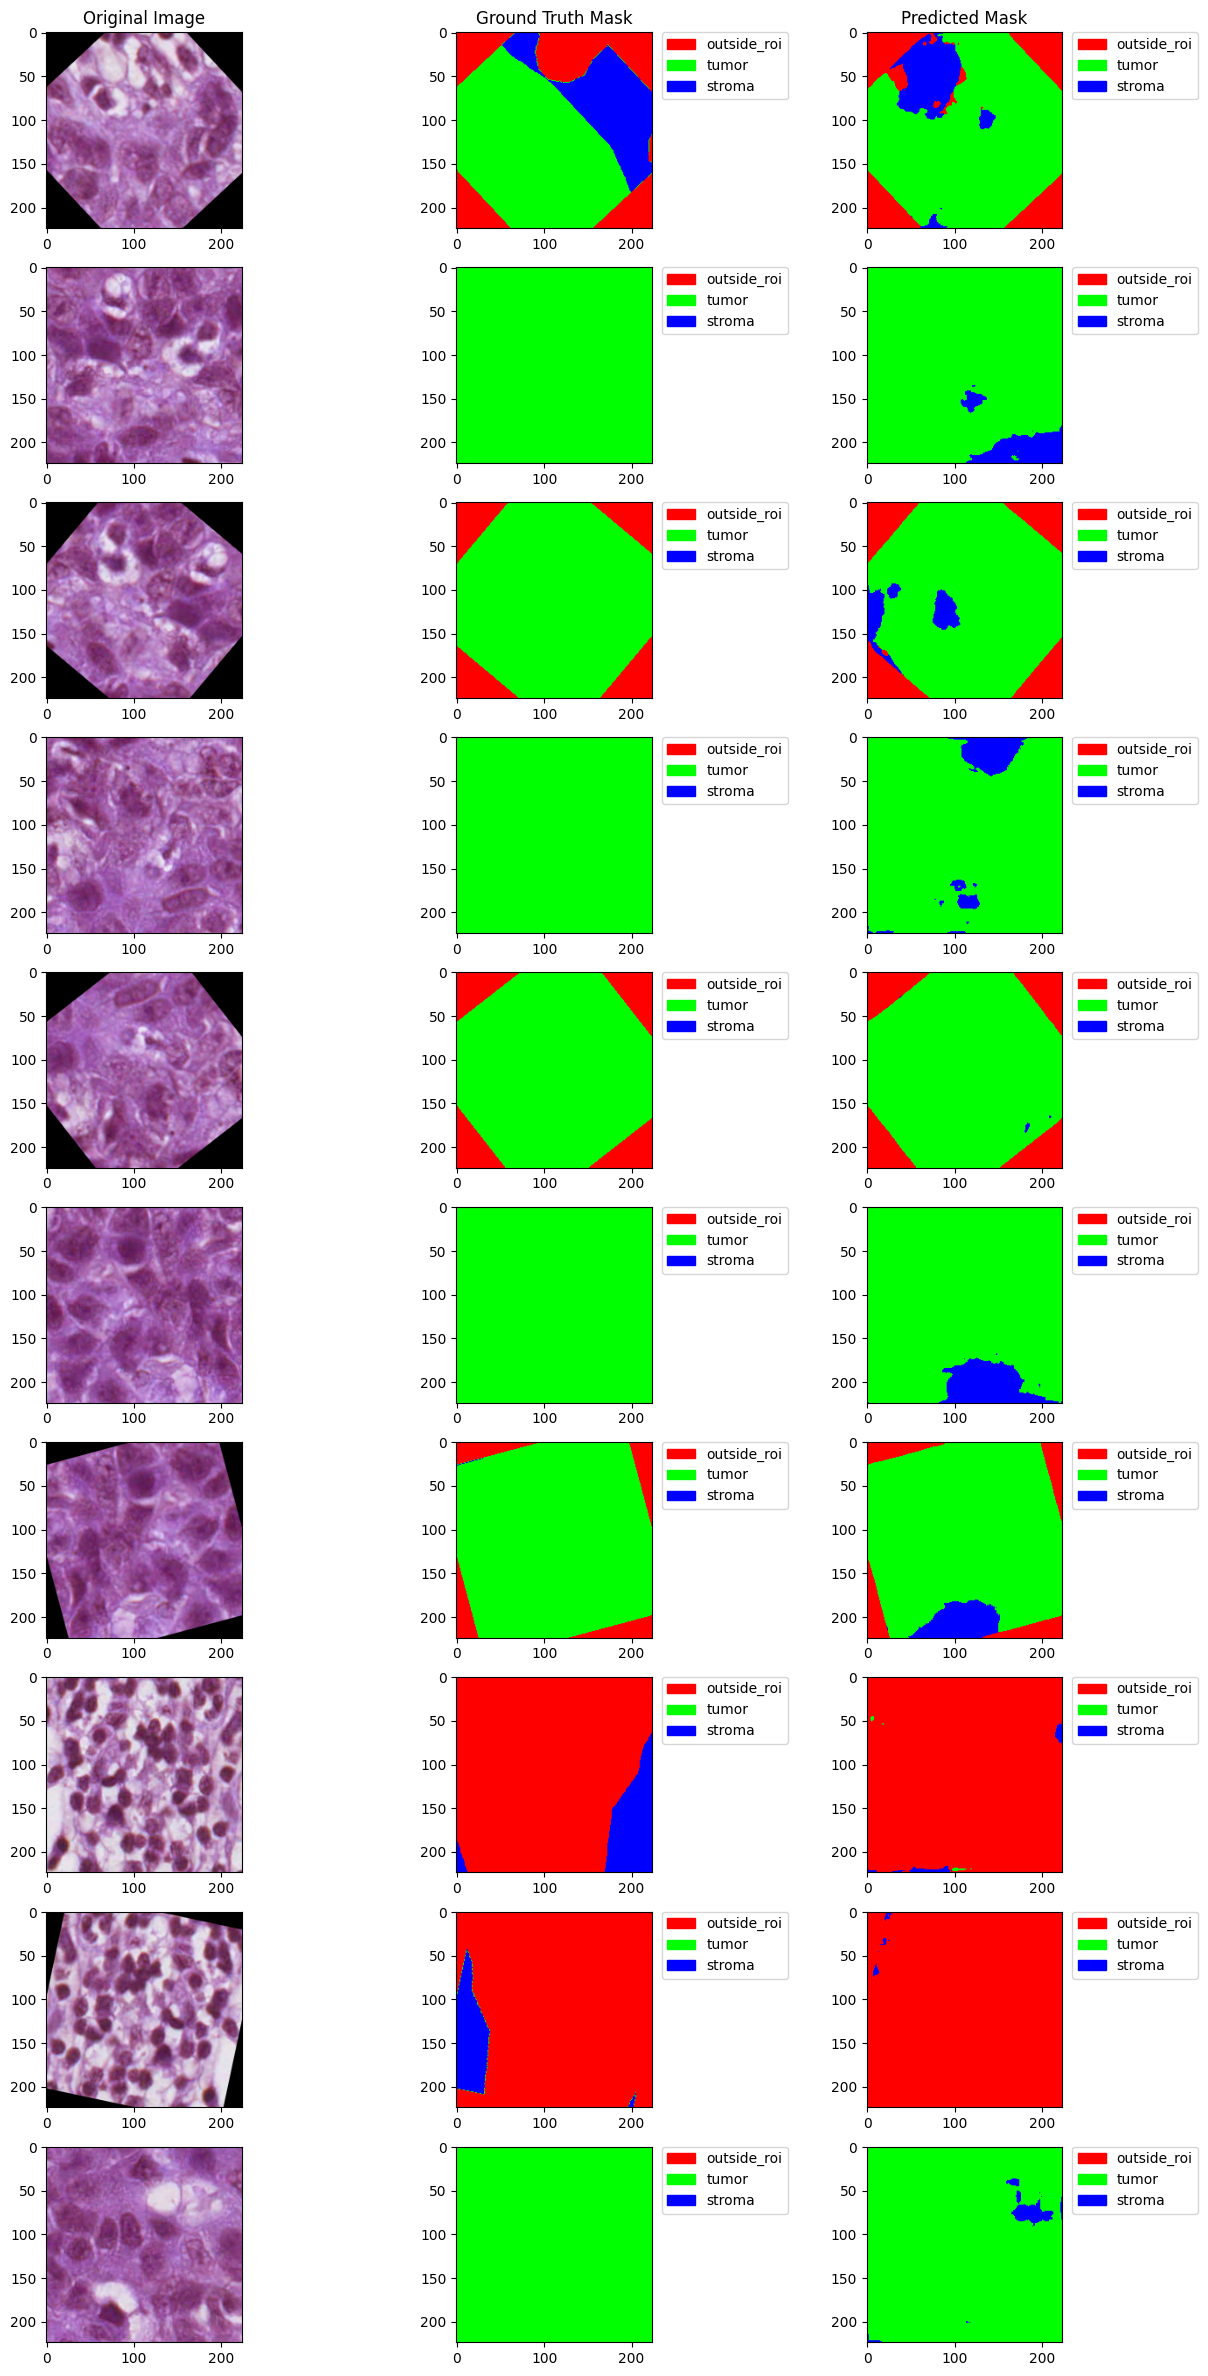

In [49]:
PlotPredictions(val_images[265:275],val_masks[265:275],mask_output,class_dict)